#  Homework 2


**Due Date: ** Friday, Febrary 9th, 2017 at 10am

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

Student: Christopher Hase

In [1]:
from sklearn.datasets import make_regression
import numpy as np
import random
from scipy.stats import norm
from matplotlib import pyplot as plt

## Problem 1: Monte Carlo Integration

Let $X$ be a random variable with distribution described by the following pdf:

$$
f_X(x) = \begin{cases}
\frac{1}{12}(x-1), &1\leq x\leq 3\\
-\frac{1}{12}(x-5), &3< x\leq 5\\
\frac{1}{6}(x-5), &5< x\leq 7\\
-\frac{1}{6}(x-9), &7< x\leq 9\\
0, &otherwise
\end{cases}
$$

Let $h$ be the following function of $X$:

$$
h(X) = \frac{1}{3\sqrt{2}\pi}\mathrm{exp}\left\{ -\frac{1}{18}\left( X - 5\right)^2\right\}
$$

Compute $\mathbb{E}[h(X)]$ via Monte Carlo simulation using the following sampling methods:
- inverse transform sampling
- rejection sampling with both uniform proposal distribution and normal proposal distribution (steroids) (with appropriately chosen parameters)

Inverse transform sampling

In [2]:
# function for computing the value of X at a given percentile in its PDF
def inverse_CDF(u):
    if u <= 1/6:
        return 1 + (24 * u)**0.5
    
    elif u > 1/6 and u <= 1/3:
        return 5 - 2 * (1 - 6 * (u - 1/6))**0.5
    
    elif u > 1/3 and u <= 2/3:
        return 5 + 2 * (3 * (u - 1/3))**0.5
    
    elif u > 2/3 and u <= 1:
        return 9 - 2 * (1 - 3 * (u - 2/3))**0.5
    
    
# function to perform inverse transform sampling from fX
def inverse_transform_samples_fX(num_samples):
    samples = np.zeros(num_samples)
    for i in range(num_samples):
        u = random.random() # sampling from unif(0,1)
        samples[i] = inverse_CDF(u) # computing value of x at the percentile of u in its PDF
        
    return samples
    

# function for computing the value of random variable h(X) given a value of the random variable X
def hX(x):
    return (1/(3 * np.pi * 2**0.5)) * np.exp((-(x - 5)**2)/18) 

In [136]:
random.seed(10)

num_samples = 1000
samples_inv_transform = inverse_transform_samples_fX(num_samples) # inverse transform sampling from fX
h_values_inv_transform = hX(samples_inv_transform) # computing random variable h(X) at values of those samples
print('Estimated mean of h(X) using inverse transform sampling: ' + str(np.mean(h_values_inv_transform)))

Estimated mean of h(X) using inverse transform sampling: 0.0589811432951


Rejection sampling

In [125]:
# function for computing the value PDF of X at x
def fX(x):
    if x >= 1 and x <= 3:
        return (1/12) * (x - 1)
    
    elif x > 3 and x <= 5:
        return (-1/12) * (x - 5)
    
    elif x > 5 and x <= 7:
        return (1/6) * (x - 5)
    
    elif x > 7 and x <= 9:
        return (-1/6) * (x - 9)
    
    else:
        return 0
    

# function to perform rejection sampling from fX
def rejection_samples_fX(proposal, num_samples, M, x_min = 1, x_max = 9, mean = 5, std = 2.5, func = fX):
    samples = np.zeros(num_samples)
    num_accepted = 0

    while(num_accepted < num_samples):
        if proposal == 'unif':
            x = np.random.uniform(x_min, x_max) # sample from unif(x_min, x_max)
            y = np.random.uniform(0, 1) # sample from unif(0, 1)

            if y < func(x)/((1/(x_max - x_min)) * M): # condition for acceptance
                samples[num_accepted] = x
                num_accepted += 1
                
        if proposal == 'normal':
            x = np.random.normal(loc = mean, scale = std) # sample from normal
            if x >= x_min and x <= x_max:
                y = np.random.uniform(0, 1) # sample from unif(0, 1)

                if y < func(x)/(norm.pdf(x, loc = mean, scale = std) * M): # condition for acceptance
                    samples[num_accepted] = x
                    num_accepted += 1
                
    return samples

In [146]:
np.random.seed(10)

num_samples = 1000
samples_unif_prop = rejection_samples_fX('unif', num_samples, 5) # rejection sampling from fX with uniform proposal distribution
h_values_unif_prop = hX(samples_unif_prop) # computing random variable h(X) at values of those samples
print('Estimated mean of h(X) using rejection sampling and uniform proposal distribution: ' + str(np.mean(h_values_unif_prop)))

samples_norm_prop = rejection_samples_fX('normal', num_samples, 5) # rejection sampling from fX with normal proposal distribution
h_values_norm_prop = hX(samples_norm_prop) # computing random variable h(X) at values of those samples
print('Estimated mean of h(X) using rejection sampling and normal proposal distribution: ' + str(np.mean(h_values_norm_prop)))

Estimated mean of h(X) using rejection sampling and uniform proposal distribution: 0.0589763007697
Estimated mean of h(X) using rejection sampling and normal proposal distribution: 0.0589816169223


## Problem 2: Variance Reduction

### Part A

Compute the variance of each estimate of $\mathbb{E}[h(X)]$ obtained in Problem 1. What do you see?

### Part B (Stratified Sampling)

Often, a complex integral can be computed with more ease if one can break up the domain of the integral into pieces and if on each piece of the domain the integral is simplified. 

- Find a natural way to divide the domain of $X$ and express $\mathbb{E}[h(X)]$ as an ***correctly*** weighted sum of integrals over the pieces of the domain of $X$. (This constitutes the essentials of Stratified Sampling)

- Estimate each integral in the summand using rejection sampling using a normal proposal distribution (with sensibly chosen parameters). From these, estimate $\mathbb{E}[h(X)]$.

- Compute the variance of your estimate of $\mathbb{E}[h(X)]$. Compare with the variance of your previous estimate of $\mathbb{E}[h(X)]$ (in Part A, using rejection sampling, a normal proposal distribution over the entire domain of $X$).

Read more about Stratified Sampling:

1. [Monte Carlo Methods](http://www.public.iastate.edu/~mervyn/stat580/Notes/s09mc.pdf)

2. [Variance Reduction Techniques Chapter](http://sas.uwaterloo.ca/~dlmcleis/s906/chapt4.pdf)

Part A

In [148]:
np.random.seed(10)

num_means = 1000
est_means_h_inv = np.zeros(num_means)
est_means_h_rej_unif = np.zeros(num_means)
est_means_h_rej_norm = np.zeros(num_means)

num_samples = 1000
for i in range(num_means):
    samples_inv_transform = inverse_transform_samples_fX(num_samples) # inverse transform sampling from fX
    h_values_inv_transform = hX(samples_inv_transform) # computing random variable h(X) at values of those samples
    est_means_h_inv[i] = np.mean(h_values_inv_transform) # estimating mean of h(X) from sample
    
    samples_rej_unif = rejection_samples_fX('unif', num_samples, 5) # rejection sampling from fX with uniform proposal distribution
    h_values_rej_unif = hX(samples_rej_unif) # computing random variable h(X) at values of those samples
    est_means_h_rej_unif[i] = np.mean(h_values_rej_unif) # estimating mean of h(X) from sample

    samples_rej_norm = rejection_samples_fX('normal', num_samples, 5) # rejection sampling from fX with normal proposal distribution
    h_values_rej_norm = hX(samples_rej_norm) # computing random variable h(X) at values of those samples
    est_means_h_rej_norm[i] = np.mean(h_values_rej_norm) # estimating mean of h(X) from sample
    
print('Estimated variance of sample mean of h(X) when using inverse transform sampling: ' + str(np.var(est_means_h_inv, ddof = 1)))
print('Estimated variance of sample mean of h(X) when using rejection sampling with uniform proposal distribution: ' + str(np.var(est_means_h_rej_unif, ddof = 1)))
print('Estimated variance of sample mean of h(X) when using rejection sampling with normal proposal distribution: ' + str(np.var(est_means_h_rej_norm, ddof = 1)))

Estimated variance of sample mean of h(X) when using inverse transform sampling: 1.01104695622e-07
Estimated variance of sample mean of h(X) when using rejection sampling with uniform proposal distribution: 1.10497011341e-07
Estimated variance of sample mean of h(X) when using rejection sampling with normal proposal distribution: 9.91070320052e-08


The estimated variances of the sample mean of h(X) are very close in magnitude.

Part B

The domain of $X$ is naturally divided into 4 parts based on its PDF $f_X$.

$E[h(X)] = P(1\leq X\leq 3)\displaystyle\int_1^3h(x)\cdot\dfrac{1}{12}(x-1) dx+P(3< X\leq 5)\displaystyle\int_3^5h(x)\cdot -\dfrac{1}{12}(x-5)dx+P(5< X\leq 7)\displaystyle\int_5^7h(x)\cdot \dfrac{1}{6}(x-5)dx+P(7< X\leq 9)\displaystyle\int_7^9h(x)\cdot -\dfrac{1}{6}(x-9)dx\\\\
=\dfrac{1}{6}\cdot\displaystyle\int_1^3h(x)\cdot\dfrac{1}{12}(x-1) dx+\dfrac{1}{6}\cdot\displaystyle\int_3^5h(x)\cdot -\dfrac{1}{12}(x-5)dx+\dfrac{1}{3}\cdot\displaystyle\int_5^7h(x)\cdot \dfrac{1}{6}(x-5)dx+\dfrac{1}{3}\cdot\displaystyle\int_7^9h(x)\cdot -\dfrac{1}{6}(x-9)dx$

In [159]:
np.random.seed(10)

num_samples = 1000

samples_13 = rejection_samples_fX('normal', num_samples, M = 2, x_min = 1, x_max = 3, mean = 2, std = 0.4, func = lambda x: (1/12) * (x - 1)) # rejection sampling from first stratum
h_values_13 = hX(samples_13) # computing random variable h(X) at values of those samples
print('Estimate of 1st integral: ' + str(np.mean(h_values_13)))

samples_35 = rejection_samples_fX('normal', num_samples, M = 2, x_min = 3, x_max = 5, mean = 4, std = 0.4, func = lambda x: (-1/12) * (x - 5)) # rejection sampling from seoond stratum
h_values_35 = hX(samples_35) # computing random variable h(X) at values of those samples
print('Estimate of 2nd integral: ' + str(np.mean(h_values_35)))

samples_57 = rejection_samples_fX('normal', num_samples, M = 2, x_min = 5, x_max = 7, mean = 6, std = 0.4, func = lambda x: (1/6) * (x - 5)) # rejection sampling from third stratum
h_values_57 = hX(samples_57) # computing random variable h(X) at values of those samples
print('Estimate of 3rd integral: ' + str(np.mean(h_values_57)))

samples_79 = rejection_samples_fX('normal', num_samples, M = 2, x_min = 7, x_max = 9, mean = 8, std = 0.4, func = lambda x: (-1/6) * (x - 9)) # rejection sampling from fourth stratum
h_values_79 = hX(samples_79) # computing random variable h(X) at values of those samples
print('Estimate of 4th integral: ' + str(np.mean(h_values_79)))

# weighted sum of integrals to estimate mean of h(X)
hX_est_mean = (1/6) * np.mean(h_values_13) + (1/6) * np.mean(h_values_35) + (1/3) * np.mean(h_values_57) + (1/3) * np.mean(h_values_79)

print('Estimated mean of h(X) using stratified sampling: ' + str(hX_est_mean))

Estimate of 1st integral: 0.0500896557542
Estimate of 2nd integral: 0.0673530001159
Estimate of 3rd integral: 0.0680925384897
Estimate of 4th integral: 0.0497164409828
Estimated mean of h(X) using stratified sampling: 0.0588434358025


In [160]:
np.random.seed(1)

num_means = 100
est_means_h_strat = np.zeros(num_means)

num_samples = 1000
for i in range(num_means):
    samples_13 = rejection_samples_fX('normal', num_samples, M = 2, x_min = 1, x_max = 3, mean = 2, std = 0.4, func = lambda x: (1/12) * (x - 1)) # rejection sampling from first stratum
    h_values_13 = hX(samples_13) # computing random variable h(X) at values of those samples

    samples_35 = rejection_samples_fX('normal', num_samples, M = 2, x_min = 3, x_max = 5, mean = 4, std = 0.4, func = lambda x: (-1/12) * (x - 5)) # rejection sampling from seoond stratum
    h_values_35 = hX(samples_35) # computing random variable h(X) at values of those samples

    samples_57 = rejection_samples_fX('normal', num_samples, M = 2, x_min = 5, x_max = 7, mean = 6, std = 0.4, func = lambda x: (1/6) * (x - 5)) # rejection sampling from third stratum
    h_values_57 = hX(samples_57) # computing random variable h(X) at values of those samples

    samples_79 = rejection_samples_fX('normal', num_samples, M = 2, x_min = 7, x_max = 9, mean = 8, std = 0.4, func = lambda x: (-1/6) * (x - 9)) # rejection sampling from fourth stratum
    h_values_79 = hX(samples_79) # computing random variable h(X) at values of those samples

    # weighted sum of integrals to estimate mean of h(X)
    est_means_h_strat[i] = (1/6) * np.mean(h_values_13) + (1/6) * np.mean(h_values_35) + (1/3) * np.mean(h_values_57) + (1/3) * np.mean(h_values_79)
    
print('Estimated variance of weighted mean of h(X) when using stratified sampling: ' + str(np.var(est_means_h_strat, ddof = 1)))

Estimated variance of weighted mean of h(X) when using stratified sampling: 9.47500939147e-09


The estimated variance of the weighted mean of $h(X)$ computed using stratified sampling with normal proposal distributions is much lower than the estimated variance of the sample mean of $h(X)$ computed using rejection sampling with a single normal proposal distribution over the entire domain of $X$.

## Problem 3: Linear Regression

Consider the following base Regression class, which roughly follows the API in the python package `scikit-learn`.

Our model is the the multivariate linear model whose MLE solution or equivalent cost minimization was talked about in lecture:

$$y = X\beta + \epsilon$$
where $y$ is a length $n$ vector, $X$ is an $n \times p$ matrix created by stacking the features for each data point, and $\beta$ is a $p$ length vector of coefficients.

The class showcases the API:

$fit(X, y)$: Fits linear model to $X$ and $y$.

$get\_params()$: Returns $\hat{\beta}$ for the fitted model. The parameters should be stored in a dictionary with keys "intercept" and "coef" that give us $\hat{\beta_0}$ and $\hat{\beta_{1:}}$. (The second value here is thus a numpy array of coefficient values)

$predict(X)$: Predict new values with the fitted model given $X$.

$score(X, y)$: Returns $R^2$ value of the fitted model.

$set\_params()$: Manually set the parameters of the linear model.



In [2]:
class Regression(object):
    
    def __init__(self):
        self.params = dict()
    
    
    def get_params(self, k):
        return self.params[k]
    
    
    def set_params(self, **kwargs):
        for k,v in kwargs.iteritems():
            self.params[k] = v
        
        
    def fit(self, X, y):
        raise NotImplementedError()
        
        
    def predict(self, X):
        raise NotImplementedError()
        
        
    def score(self, X, y):
        raise NotImplementedError()

### Part A:  a class for Ordinary Least Squares

Inherit from this class to create an ordinary Least Squares Linear Regression class. 

It's signature will look like this:

`class OLS(Regression):`

Implement `fit`, `predict` and `score`. This will involve some linear algebra. (You might want to read up on pseudo-inverses before you directly implement the linear algebra on the lecure slides).

#### $R^2$ score

To implement `score`, look below:

The $R^2$ score is defined as: $${R^{2} = {1-{SS_E \over SS_T}}}$$

Where:

$$SS_T=\sum_i (y_i-\bar{y})^2, SS_R=\sum_i (\hat{y_i}-\bar{y})^2, SS_E=\sum_i (y_i - \hat{y_i})^2$$
where  ${y_i}$ are the original data values, $\hat{y_i}$ are the predicted values, and $\bar{y_i}$ is the mean of the original data values.



In [115]:
class OLS(Regression):
    
    def __init__(self):
        self.params = dict()
        
        
    def fit(self, X, y):
        # adding column of ones to X matrix to fit bias term if X matrix doesn't already have a column of ones
        if np.sum(X[:, 0] != np.ones(X.shape[0])) == X.shape[0]:
            X_ones = np.concatenate((np.ones((X.shape[0], 1)), X), axis = 1)
        else:
            X_ones = X
        
        betas = np.linalg.pinv(X_ones.T.dot(X_ones)).dot(X_ones.T).dot(y) # ordinary least squares solution
        self.params['intercept'] = betas[0]
        self.params['coef'] = betas[1:]
        
        
    def predict(self, X):
        # adding column of ones to X matrix if X matrix doesn't already have a column of ones
        if np.sum(X[:, 0] != np.ones(X.shape[0])) == X.shape[0]:
            X_ones = np.concatenate((np.ones((X.shape[0], 1)), X), axis = 1)
        else:
            X_ones = X
        
        # putting intercept and coefficients into a single column vector
        betas = np.concatenate((np.array(self.params['intercept']).reshape(1, -1), self.params['coef'].reshape(len(self.params['coef']), -1)), axis = 0)
                               
        return np.squeeze(X_ones.dot(betas), axis = 1)
    
        
    def score(self, X, y):
        pred = self.predict(X)
        sse = np.sum((y - pred)**2)
        sst = np.sum((y - np.mean(y))**2)
        
        return 1 - sse/sst

### Part B: test your code

We'll create a synthetic data set using the code below. (Read the documentation for `make_regression` to see what is going on).

In [39]:
np.random.seed(99)
X, y, coef = make_regression(30, 10, 10, bias=1, noise=2, coef=True)
coef

array([ 76.6568183 ,  77.67682678,  63.78807738,  19.3299907 ,
        59.01638708,  53.13633737,  28.77629958,  10.01888939,
         9.25346811,  59.55220395])

Verify that your code recovers these coefficients approximately on doing the fit. Plot the predicted `y` against the actual `y`. Also calculate the score using the same sets `X` and `y`. The usage will look something like:

```python
lr = OLS()
lr.fit(X, y)
lr.get_params['coef']
lr.predict(X)
lr.score(X, y)
```

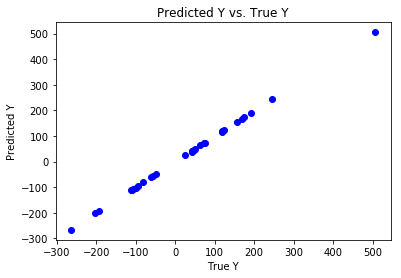

Intercept: 1.34580357078

Coefficients: [ 77.20719705  76.51004831  62.97865316  18.4436452   58.50019885
  53.25126559  28.29088241   9.33333359  10.29584457  59.1606719 ]

Predictions: [  48.57564537   24.85508406  246.39920911   64.72282184  124.00042911
 -266.57653702  118.15510334 -108.57077603  191.15229644  174.74404249
 -103.59066227  -59.1576374   -54.70947468   73.91003582  505.22781806
   39.53820436 -191.02175593 -201.71787963   46.1500923  -111.90307749
  117.38777883 -111.52335297   41.66543625  168.33074858   73.41934029
  -80.64319083  155.12182695  -94.18157131  -48.17239883   40.78548557]

Score (R^2): 0.999915583206


In [118]:
# fitting and predicting
lr = OLS()
lr.fit(X, y)
pred = lr.predict(X)

# plotting pred y vs. true y
plt.plot(y, pred, 'bo')
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.title('Predicted Y vs. True Y')
plt.show()

# displaying values of interest
print('Intercept: ' + str(lr.get_params('intercept')))
print()
print('Coefficients: ' + str(lr.get_params('coef')))
print()
print('Predictions: ' + str(pred))
print()
print('Score (R^2): ' + str(lr.score(X, y)))